# Better QR codes
> Snake Race codes to replace QR codes. With NumPy, rotation matrix and animated images!
- image: images/copied_from_nb/animation.gif


QR codes are quite interesting, but boring to look at. For this reason I introduce SR codes, which stands for Snake Race codes. It improves QR codes on several fronts:

* Animation!
* Color!
* Hardcore. QR codes have error correction. SR codes don't. If you make an error it's game over.
* Not quick. Savour the wait before you can scan the code.

Developing a scanner app is left as an exercise for the reader :)


![](animation.gif) ![](qrcode.png)

QR codes are really interesting. Error correction and packing as much information as you can in a small amount of pixels while keeping it robust is a nice challenge.

Nice explanation in Dutch [https://michielp1807.github.io/qr-codes/](https://michielp1807.github.io/qr-codes/) or check out the [Wikipedia page](https://en.wikipedia.org/wiki/QR_code).

In [3]:
#hide
import numpy as np
from typing import NamedTuple, Tuple
from numpy.random import default_rng
from matplotlib import cm
from PIL import Image, ImageDraw
import numpy as np
from typing import NamedTuple, Tuple
from numpy.random import default_rng
from matplotlib import cm
from PIL import Image, ImageDraw

## Representing position and orientation

We represent the position of the snake as a point $(x, y)$ with an orientation $(h, v)$. Taking turns is done with a _rotation matrix_ that defines 90 degree turns and going straight (=not changing direction).

In [4]:
actions = [
    # Left
    np.array([
        [0, 1],
        [-1, 0]
    ]),
    # Straight
    np.array([
        [1, 0],
        [0, 1]
    ]),  
    # Right
    np.array([
        [0, -1],
        [1, 0]
    ])
]

For example, if the snake is going to the right it has orientation $(1,0)$. If it makes a 90 degree turn to the left it goes up and has orientation $(0, -1)$. The first coordinate is horizontal and the second is vertical.

In [17]:
actions[0] @ np.array([1, 0])

array([ 0, -1])

Going left four times we should end up in the same direction:

In [19]:
orientation = np.array([1, 0])
for i in range(4):
    orientation = actions[0] @ orientation
orientation

array([1, 0])

## Going places
We want to see where the snakes have been as well as their current position. Below we define:

- The different snakes in `snakes`, including start position, color and trail
- For each snake we also keep track if they are active. The snake stops if there is no valid move to make.
- To make our lives easy we have per position the information if some snake has been there to limit possible moves `matrix`

Define a method to generat the _trails_ of the snakes

In [30]:
def generate_trails(size: int, bits):
    # Define quarter distance
    q = size // 4
    
    # Define the start positions of all snakes
    snakes = [
        {
            'c': 'Greens', 
            'position': np.array([q+1, q+1]), 
            'orientation':  np.array([1, 0]), 
            'trail': np.full((2*(size+2), 2*(size+2)), 0),
            'active': True
        },
        {
            'c': 'Reds', 
            'position': np.array([3*q+1, 1+1]), 
            'orientation': np.array([0, 1]), 
            'trail': np.full((2*(size+2), 2*(size+2)), 0),
            'active': True
        },
        {
            'c': 'Blues', 
            'position': np.array([3*q+1, 3*q+1]), 
            'orientation': np.array([-1, 0]), 
            'trail': np.full((2*(size+2), 2*(size+2)), 0),
            'active': True
        },
        {
            'c': 'Purples', 
            'position': np.array([q+1, 3*q+1]), 
            'orientation': np.array([0, -1]), 
            'trail': np.full((2*(size+2), 2*(size+2)), 0),
            'active': True
        }
    ]
    

    # Keep track of where the snakes have passed
    matrix = np.full((size+2, size+2), False)
    
    # Set the borders
    matrix[0, :] = True
    matrix[:, 0] = True
    matrix[-1, :] = True
    matrix[:, -1] = True
    
    # Go over the bits
    current_bit = 0
    iteration = 0
    
    # While there are active snakes try it out
    while any([snake['active'] for snake in snakes]):

        # For each active snake
        active_snakes = [snake for snake in snakes if snake['active']]
        for i, snake in enumerate(active_snakes) :
           
            # Get the bit or exit
            if current_bit >= len(bits):
                return snakes
            
            bit = bits[current_bit]
            
            # Get the possible actions
            possible_actions = [ 
                action for action in actions 
                if not matrix[ tuple(snake['position'] + action @ snake['orientation']) ] 
            ]

            # Execute an action
            if len(possible_actions) == 0:
                snake['active'] = False
                continue  # See if other snakes can still play
                
            elif len(possible_actions) == 1:
                action = possible_actions[0]
                
            elif len(possible_actions) == 2:
                action = possible_actions[int(bit)]
                
            elif len(possible_actions) == 3:
                offset = iteration % 2
                action = possible_actions[(int(bit) + offset)]

            # Update
            current_bit += 1
            snake['orientation'] = action @ snake['orientation']
            prev_position = snake['position']
            snake['position'] = snake['position'] + snake['orientation']

            # Update boundaries where snakes have been
            matrix[ tuple(snake['position']) ] = True

            # Update the twice larger pretty image (so that there is space and it looks pretty)
            snake['trail'][ tuple(prev_position + snake['position']) ] = 2 * iteration
            snake['trail'][tuple(2 * snake['position']) ] = 2 * iteration + 1
        
        # Update iteration
        iteration += 1

    return snakes, current_bit, iteration

## Showing it on screen
Some code that generates the image at a certain frame/point in time:

In [31]:
def generate_image(snakes, frame=np.inf, canvas_size = 44):

    
    # Define a transparant layer
    transparent = np.uint8(np.broadcast_to(
        np.array([255, 255, 255, 0]), 
        (canvas_size, canvas_size, 4)
    ))
    
    # Define the bottom layer (transparent white)
    composite = Image.new(
        'RGBA', 
        (canvas_size, canvas_size), 
        (255, 255, 255, 255)
    )

    # Draw each trail
    for snake in snakes:
        # Get the trail until this frame
        trail = snake['trail'] * (snake['trail'] <= frame)
        
        # Get the color
        color = cm.get_cmap(snake['c'])
        
        # Set the trail and rest transparent
        df = np.where(
            trail[:, :, np.newaxis] > 0, 
            np.uint8(color(trail / trail.max())  *255), 
            transparent
        )
        
        # Create an image and add the layer
        im = Image.fromarray(df)
        composite = Image.alpha_composite(composite, im)

    d = ImageDraw.Draw(composite)
    d.rectangle(
        [(0, 0), (canvas_size-1, canvas_size-1)], 
        fill=None, 
        outline=(0,0,0,255), 
        width=1)
    
    return composite.resize((5 * canvas_size, 5 * canvas_size), Image.NEAREST)


For this piece of code we'll generate 500 bits on a canvas of 22x22. The bits are not generated efficiently.

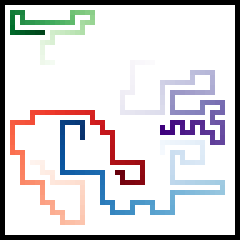

In [32]:
# Some settings
seed = 0
nr_bits = 500
size = 22

# Sizes of the canvas
canvas_size=2*(2+size)
canvas_size_xl = canvas_size * 5

# Generate some random bits
rng = default_rng(seed)
bits = rng.random(nr_bits) < 0.5

# Get the trails
snakes, nr_generated, max_iteration = generate_trails(
    size,
    bits
)

# Display
image = generate_image(snakes, frame=max_iteration, canvas_size=canvas_size)
display(image)

## Animation
Finally we create a GIF image

In [33]:
# Create a gif
gif = Image.new('RGBA', (canvas_size_xl, canvas_size_xl))

gif.save('animation.gif', 
         save_all=True, 
         append_images=[generate_image(snakes, frame=frame, canvas_size=canvas_size) 
                        for frame in range(2, max_iteration)],
         duration=100, 
         loop=0)

![](animation.gif)